### **1- Data Processing for Machine Learning:**
- (e.g., detect and deal with noise (i.e., erroneous
    values), missing values, and outliers; categorically-encode,rescale data; split data into predictors and target; obtain train/validation/test folds).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycebox.ice import ice, ice_plot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Load dataset
df = pd.read_csv('adverts.csv')

In [10]:
df.describe(exclude='number')


,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,body_type,crossover_car_and_van,fuel_type
count,370148,396627,402005,402005,402005,401168,402005,401404
unique,72,22,110,1168,2,16,2,9
top,17,Black,BMW,Golf,USED,Hatchback,False,Petrol
freq,36738,86287,37376,11583,370756,167315,400210,216929


In [4]:
df.describe()

,public_reference,mileage,year_of_registration,price
count,4.020050e+05,401878.000000,368694.000000,4.020050e+05
mean,2.020071e+14,37743.595656,2015.006206,1.734197e+04
std,1.691662e+10,34831.724018,7.962667,4.643746e+04
min,2.013072e+14,0.000000,999.000000,1.200000e+02
25%,2.020090e+14,10481.000000,2013.000000,7.495000e+03
50%,2.020093e+14,28629.500000,2016.000000,1.260000e+04
75%,2.020102e+14,56875.750000,2018.000000,2.000000e+04
max,2.020110e+14,999999.000000,2020.000000,9.999999e+06


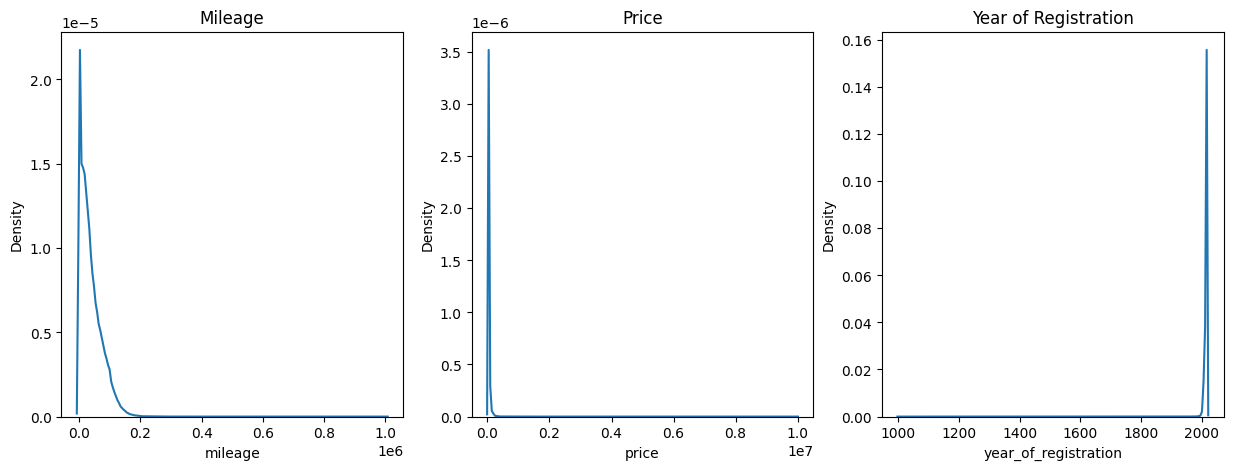

In [15]:
# Set the size of the figure
fig_size = (15, 5)

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=fig_size)

# Plot the distribution of mileage
sns.kdeplot(data=df['mileage'], ax=axes[0])
axes[0].set_title('Mileage')

# Plot the distribution of price
sns.kdeplot(data=df['price'], ax=axes[1])
axes[1].set_title('Price')

# Plot the distribution of year of registration
sns.kdeplot(data=df['year_of_registration'], ax=axes[2])
axes[2].set_title('Year of Registration')

# Display the figure
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [2]:
# Drop irrelevant columns
df.drop(['public_reference', 'reg_code', 'crossover_car_and_van'], axis=1, inplace=True)

# Encode categorical variables
categorical_cols = ['standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'fuel_type']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df['mileage'] = df['mileage'].astype('float32')
df['year_of_registration'] = df['year_of_registration'].astype('float32')

# Handle missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :7] = imputer.fit_transform(df.iloc[:, :7])


# Calculate the interquartile range (IQR) for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Find the outliers for each column using IQR
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
# Remove the outliers from the dataframe
df = df[~outliers]
# Use the cleaned data for modeling
X = df.drop('price', axis=1)
y = df['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def preprocess_data(df, current_year):
    # Feature engineering
    df['age'] = current_year - df['year_of_registration']
    df['odometer_reading'] = df['mileage'] / df['age']
    df.drop(['mileage', 'year_of_registration'], axis=1, inplace=True)
    return df
# Apply the same feature engineering steps to both the training and test datasets
current_year = 2023
X_train = preprocess_data(X_train, current_year)
X_test = preprocess_data(X_test, current_year)

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### **2- Feature Engineering:**
- (e.g., derive features based on domain knowledge; produce polyno-mial/basis functions and interaction features).

In [3]:
# Transform the training and testing data using polynomial features
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


### **3- Feature Selection and Dimensionality Reduction:**
- (e.g., perform manual selection guided by domain knowledge and exploratory data analysis, run automated selection algorithms for most useful predictors).

In [4]:
# Perform feature selection using SelectKBest
k = 5 # number of top features to select
selector = SelectKBest(f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_poly, y_train)
X_test_selected = selector.transform(X_test_poly)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)

# Get the names of the selected features
feature_names = poly.get_feature_names_out(input_features=X.columns)[selected_features]

print(feature_names)


['body_type' 'standard_colour body_type' 'year_of_registration body_type'
 'body_type^2' 'body_type fuel_type']


### **4- Model Building:**
- (e.g., choose suitable algorithm(s), fit and tune models; grid-search, rank, and select model(s) on based on evaluation metrics and under/overfit trade-off; build an ensemble with best performing models/configurations).

In [5]:
# Select the k best features from X_train and X_test
X_train_selected = X_train_poly[:, selected_features]
X_test_selected = X_test_poly[:, selected_features]

# Fit a linear regression model
lr = LinearRegression()
lr.fit(X_train_selected, y_train)

# Define the hyperparameter grid for the random forest model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
# Create a random forest model
rf = RandomForestRegressor()
# Create a grid search object for the random forest model
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
# Fit the grid search object to the data
grid_search.fit(X_train_selected, y_train)
# Get the best random forest model
best_rf = grid_search.best_estimator_
# Fit the best random forest model to the data
best_rf.fit(X_train_selected, y_train)

# Fit a boosted tree model
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train_selected, y_train)

# Fit an ensemble model using voting
ensemble = VotingRegressor([('lr', lr), ('rf', best_rf), ('gb', gb)])
ensemble.fit(X_train_selected, y_train)


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   min_samples_split=5,
                                                   n_estimators=50)),
                            ('gb', GradientBoostingRegressor())])

### **5- Model Evaluation and Analysis:**
- (e.g., evaluate selected model(s) according to popular score and loss metrics with cross-validation, analyse true vs predicted plot, gain and discuss insights based on feature importance and model output space).

Cross-validation scores: [0.60408674 0.60265108 0.60310014 0.59721529 0.60475666]
Mean squared error: 24195072.11240813
Coefficient of determination (R^2): 0.6012259376095825


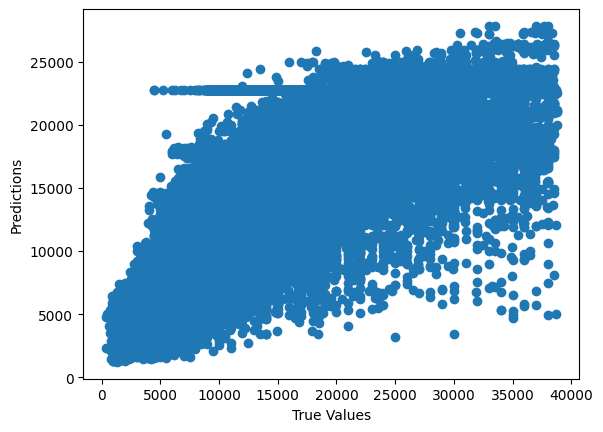

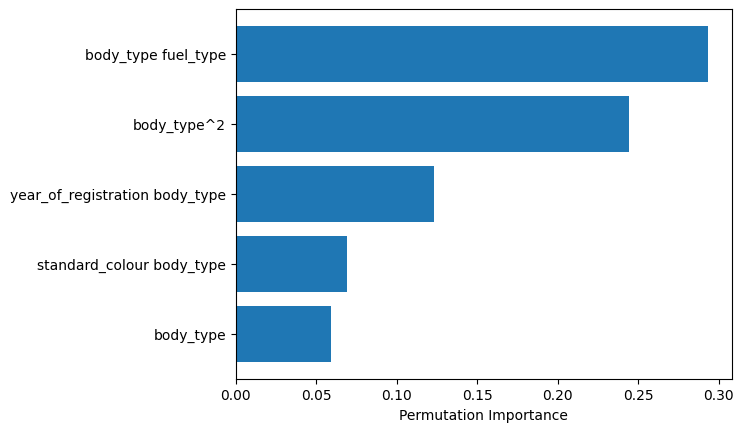

In [6]:
# Evaluate the model using cross-validation
scores = cross_val_score(ensemble, X_train_selected, y_train, cv=5)
print('Cross-validation scores:', scores)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_selected)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)
# Calculate the coefficient of determination (R^2)
r2 = r2_score(y_test, y_pred)
print('Coefficient of determination (R^2):', r2)

# Plot true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# Calculate feature importance using permutation importance
result = permutation_importance(ensemble, X_test_selected, y_test, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
# Create a horizontal bar plot to visualize feature importance
plt.barh(range(k), result.importances_mean[sorted_idx][-k:])
plt.yticks(range(k), feature_names)
plt.xlabel('Permutation Importance')
plt.show()


body_type: 0.293
standard_colour body_type: 0.244
year_of_registration body_type: 0.123
body_type fuel_type: 0.069
body_type^2: 0.059


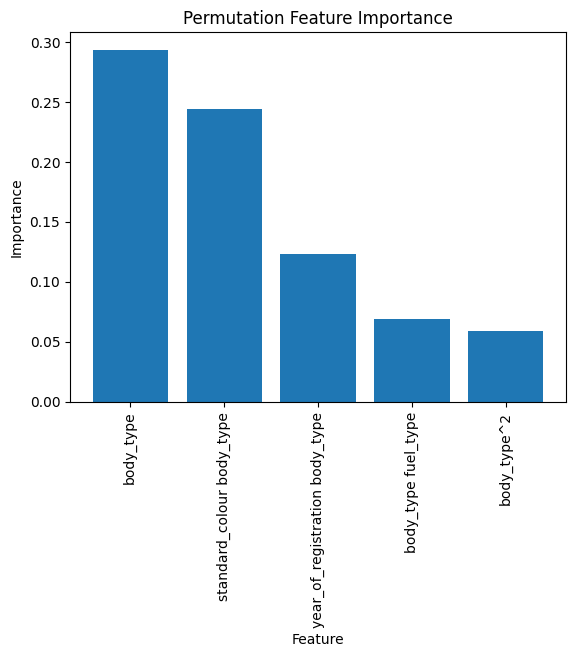

In [10]:
# Calculate feature importance using permutation importance for the ensemble model
result = permutation_importance(ensemble, X_test_selected, y_test, n_repeats=10, random_state=0)
for i in result.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f}")

importances = result.importances_mean
sorted_idx = importances.argsort()[::-1]
features = np.array(feature_names)[sorted_idx]

plt.bar(features, importances[sorted_idx])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.show()
